In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split



In [2]:
training_vars = ['jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']


# Load Data

In [3]:
sample_path = '../../../samples/sample_1500_200k_jets.pkl'
sample = pd.read_pickle(sample_path)

In [4]:
sample.columns

Index(['jet_pt', 'jet_eta', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1',
       'jet_trackBDT', 'jet_PartonTruthLabelID', 'equal_weight',
       'event_weight', 'flatpt_weight', 'is_forward', 'target'],
      dtype='object')

# Train with default config

In [5]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [6]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [7]:
X_train[training_vars].head()

,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1
2566883,0.679515,23.0,0.025677,0.207664
6556582,1.368410,15.0,0.009414,0.030910
2043041,0.060150,35.0,0.023107,0.206650
2739237,0.421534,23.0,0.040388,0.239528
2198553,0.521471,37.0,0.055931,0.028974


In [8]:
X_train[training_weight].head()

,equal_weight
2566883,1.0
6556582,1.0
2043041,1.0
2739237,1.0
2198553,1.0


In [9]:
dt = DecisionTreeClassifier(max_depth=9,
                            min_samples_leaf=0.001,
                            max_features='log2')
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=42)

bdt.fit(X_train[training_vars], y_train, sample_weight=X_train[training_weight].to_numpy().flatten())

### 27m

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(max_depth=9,
                                                         max_features='log2',
                                                         min_samples_leaf=0.001),
                   learning_rate=0.1, n_estimators=500, random_state=42)

In [10]:
bdt_filename = './BDT_explore_1500_ntrk_equalweight.model'
pickle.dump(bdt, open(bdt_filename, 'wb'))

# Predict on test datasets

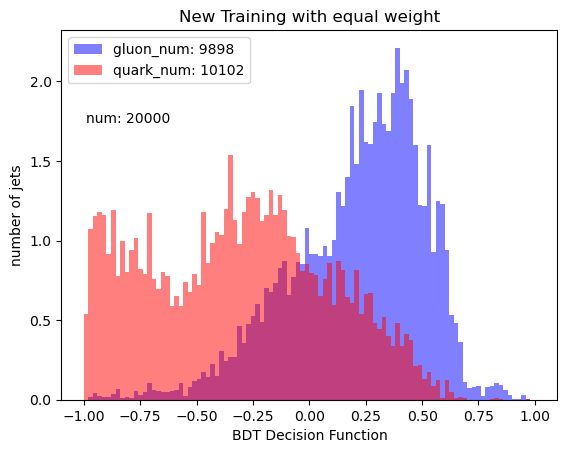

In [11]:
y_test_decisions = bdt.decision_function(X_test[training_vars])
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(-1, 1, 101)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, X_test.columns.get_loc('event_weight')], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"New Training with equal weight")
plt.savefig(r"Histo_testscores")
plt.show()

# ROC

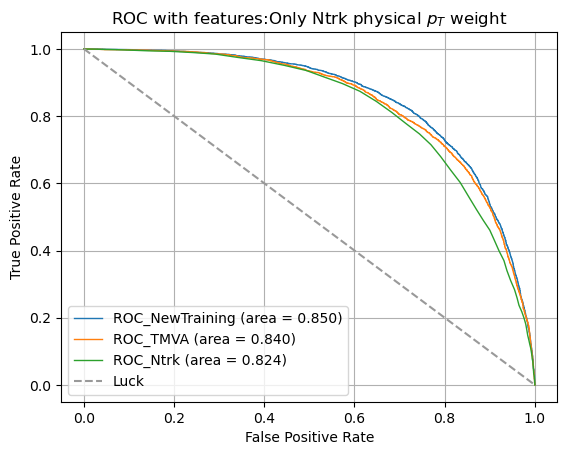

In [12]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_NewTraining (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC_physicalweight.png")
    plt.show()

Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features="Only Ntrk")


# Overtrain validation

In [13]:
y_test_decisions = bdt.decision_function(X_test[training_vars])
y_train_decisions = bdt.decision_function(X_train[training_vars])


y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)

Text(0.5, 1.0, 'Overtraining test')

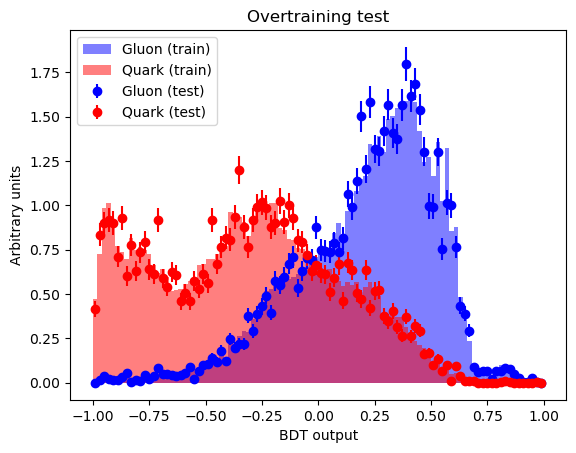

In [14]:
custom_bins = np.linspace(-1, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_train.iloc[np.where(y_train==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_train.iloc[np.where(y_train==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_test.iloc[np.where(y_test==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_test.iloc[np.where(y_test==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("BDT output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")

# Check Forward/Central 

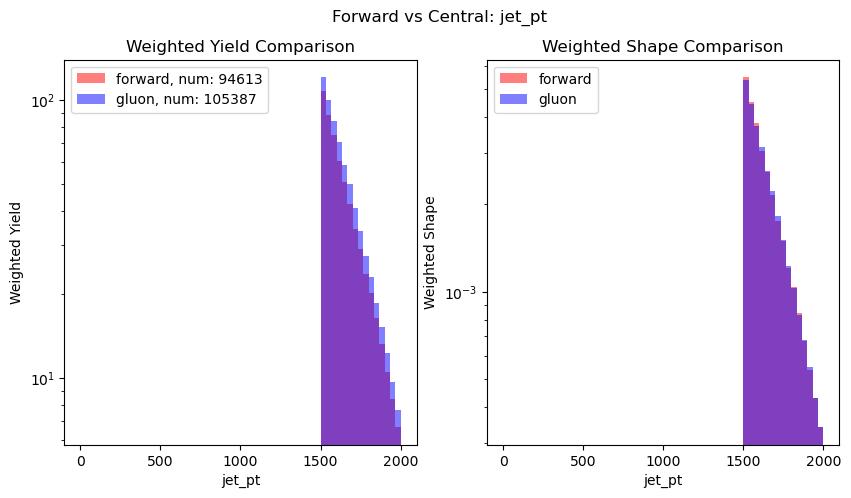

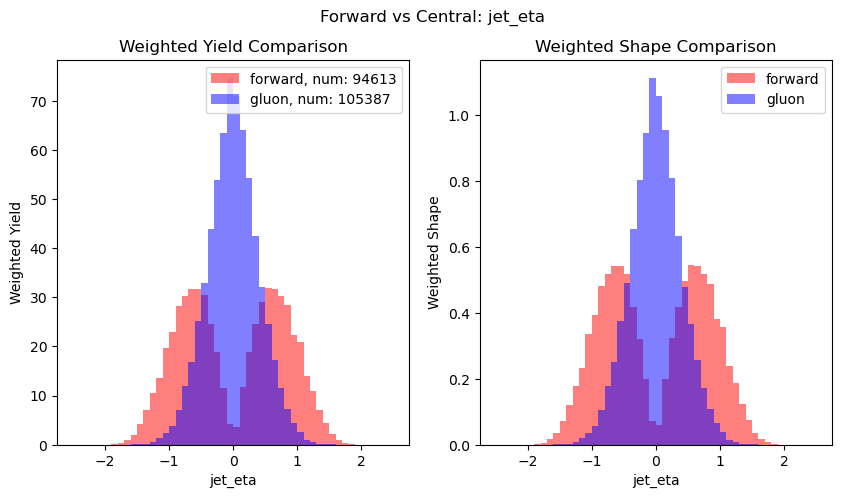

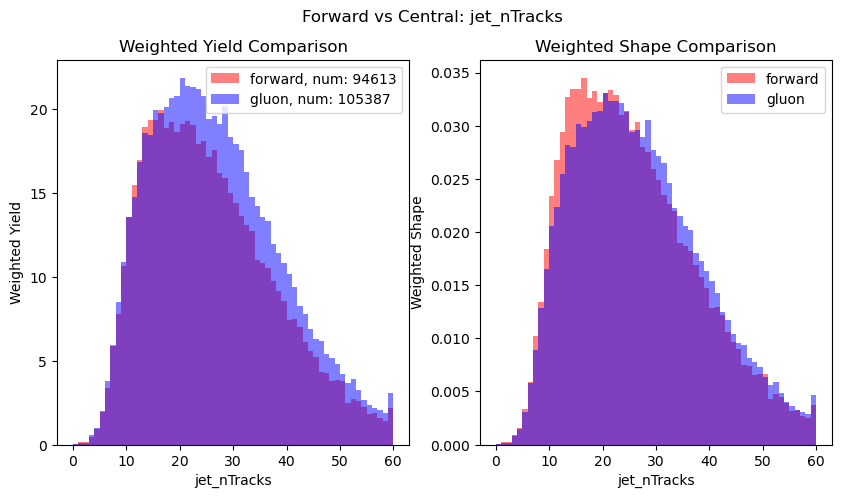

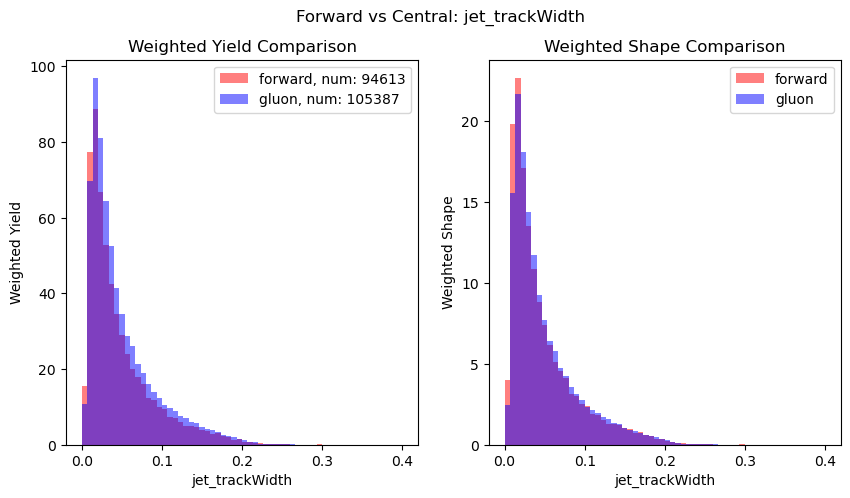

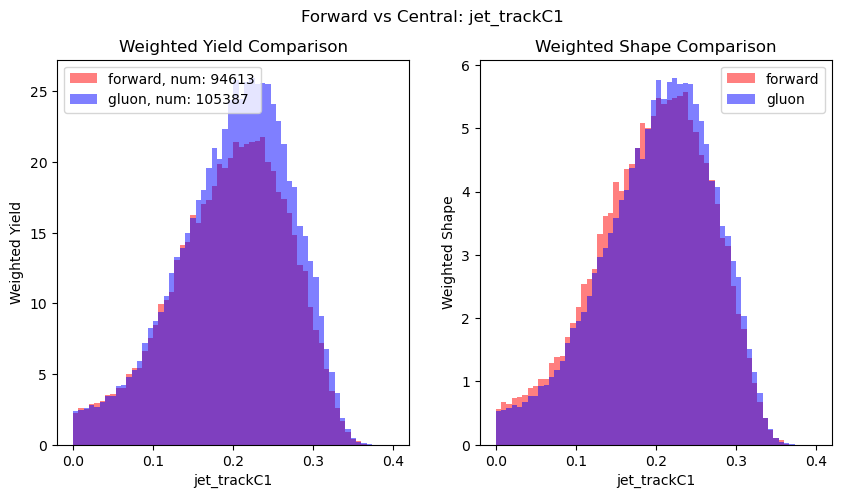

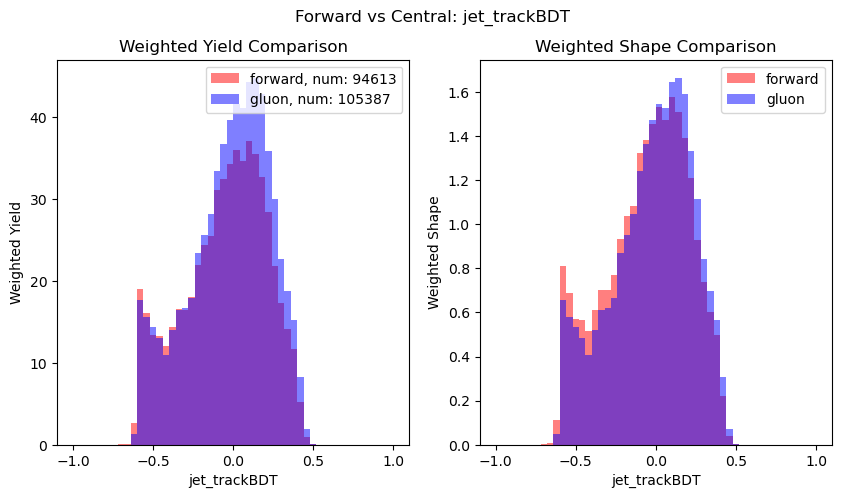

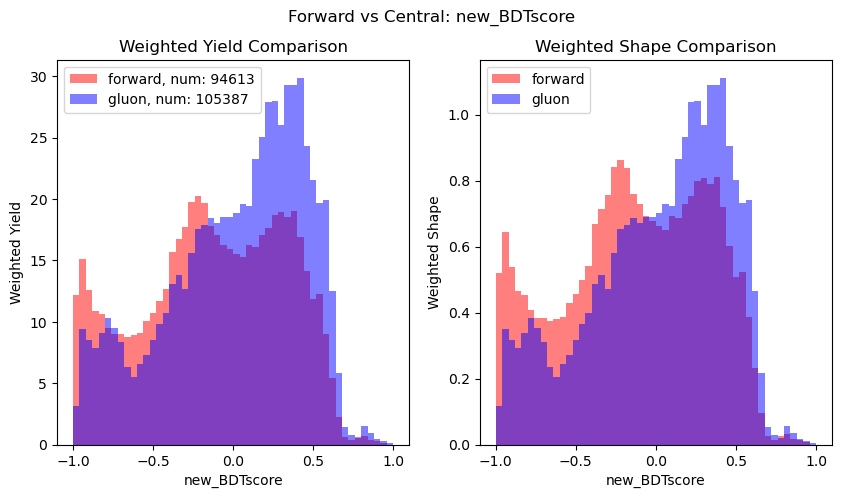

In [15]:
y_sample = bdt.decision_function(sample[training_vars])
sample['new_BDTscore'] = y_sample

features = [*sample.columns[:6]] + ['new_BDTscore'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(-1.0, 1.0, 51),
}

sample_forward = sample[sample['is_forward']==1]
sample_central = sample[sample['is_forward']==0]

for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'gluon, num: {len(sample_central)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()
    

In [16]:
bdt.feature_importances_

array([0.17631613, 0.47905475, 0.18082354, 0.16380559])

In [17]:
sample['new_BDTscore'].head()

6706892    0.534201
1587200   -0.803372
426696    -0.747991
6161255    0.263075
1468284   -0.774502
Name: new_BDTscore, dtype: float64

In [18]:
bdt_decision_score_bins = np.array([-1.0, -0.65, -0.35, 0, 1])
sample['new_BDTscore_bin'] = pd.cut(sample['new_BDTscore'], bdt_decision_score_bins, labels=np.arange(bdt_decision_score_bins.shape[0]-1))
# binned_idx = np.digitize(y_test_decisions[y_test_quark_id], bdt_decision_score_bins)
# for bin_idx in range(len(bdt_decision_score_bins)):
#     idx = np.where((binned_idx - 1) == bin_idx)[0]
#     y_test = y_test_decisions[idx]
    

In [19]:
np.arange(bdt_decision_score_bins.shape[0])

array([0, 1, 2, 3, 4])

In [20]:
sample

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,target,new_BDTscore,new_BDTscore_bin
6706892,1660.925903,-0.327346,50.0,0.114803,0.297325,0.271640,2.0,1.0,0.009957,0.000005,0.0,0.0,0.534201,3
1587200,1797.460083,-0.242264,11.0,0.015993,0.150885,-0.442552,2.0,1.0,0.001961,0.000002,0.0,0.0,-0.803372,0
426696,1863.581787,-0.851044,14.0,0.006867,0.121171,-0.399513,2.0,1.0,0.001762,0.000003,1.0,0.0,-0.747991,0
6161255,1668.149536,-0.618140,27.0,0.030701,0.211032,0.114346,1.0,1.0,0.010364,0.000005,1.0,0.0,0.263075,3
1468284,1949.918335,0.865044,11.0,0.024530,0.021959,-0.462118,2.0,1.0,0.001660,0.000004,0.0,0.0,-0.774502,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1057686,1658.879395,-0.321857,50.0,0.134610,0.324097,0.248569,21.0,1.0,0.002897,0.000001,1.0,1.0,0.539245,3
2974300,1947.666260,-0.166996,19.0,0.044877,0.239231,-0.114391,21.0,1.0,0.001936,0.000005,0.0,1.0,0.019452,3
1694645,1779.499390,0.999938,21.0,0.024578,0.156607,-0.161730,21.0,1.0,0.002192,0.000002,1.0,1.0,-0.346068,2
4277790,1571.704346,0.069496,41.0,0.062764,0.272629,0.283243,21.0,1.0,0.007783,0.000002,0.0,1.0,0.507705,3


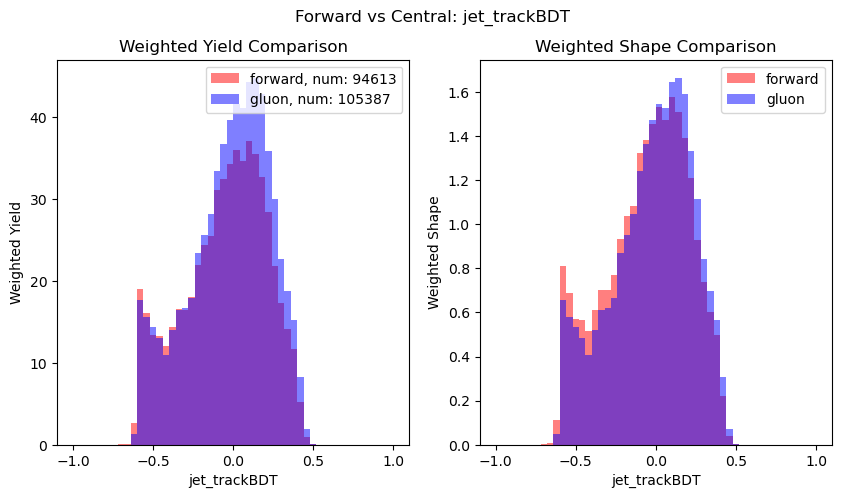

In [21]:
sample_forward = sample[sample['is_forward']==1]
sample_central = sample[sample['is_forward']==0]

for feature_name in features[-2:-1]:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'gluon, num: {len(sample_central)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'gluon', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()

### Prob vs decision score

In [22]:
y_sample_score = bdt.decision_function(sample[training_vars])
y_sample_prob = bdt.predict_proba(sample[training_vars])


In [23]:
y_sample_score

array([ 0.5342012 , -0.80337216, -0.74799058, ..., -0.34606798,
        0.50770518,  0.584896  ])

In [24]:
y_sample_prob

array([[0.36953756, 0.63046244],
       [0.69069536, 0.30930464],
       [0.6787407 , 0.3212593 ],
       ...,
       [0.58566375, 0.41433625],
       [0.37573164, 0.62426836],
       [0.3578068 , 0.6421932 ]])

Text(0.5, 0.98, 'decision_score vs. pred_proba')

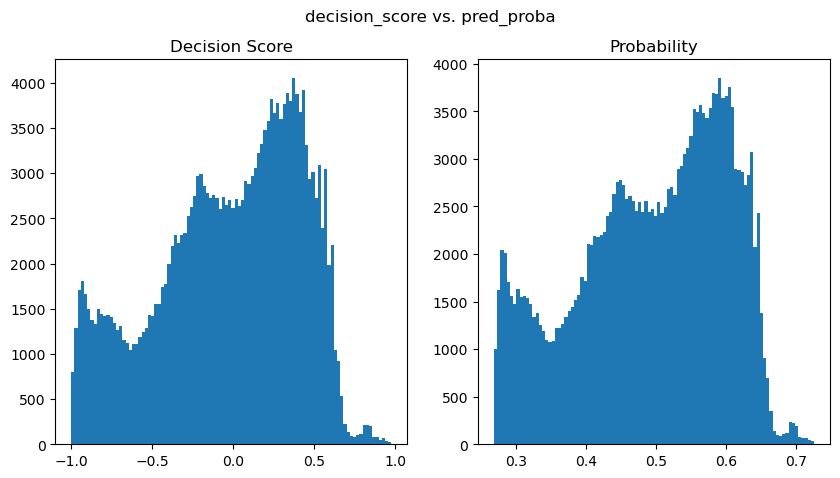

In [25]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (5*2, 5))
ax0.hist(y_sample_score, bins = 100)
ax0.set_title('Decision Score')
ax1.hist(y_sample_prob[:,1], bins = 100)
ax1.set_title('Probability')

fig.suptitle('decision_score vs. pred_proba')

In [26]:
from scipy.special import softmax
expand = np.vstack([-y_sample_score, y_sample_score]).T / 2
softmax(expand, axis = 1)

array([[0.36953756, 0.63046244],
       [0.69069536, 0.30930464],
       [0.6787407 , 0.3212593 ],
       ...,
       [0.58566375, 0.41433625],
       [0.37573164, 0.62426836],
       [0.3578068 , 0.6421932 ]])

In [27]:
exp = np.exp(expand[0])
exp / np.sum(exp)

array([0.36953756, 0.63046244])

[Text(0.5078832470892626, 0.95, 'X[1] <= 22.5\ngini = 0.5\nsamples = 160000\nvalue = [0.499, 0.501]'),
 Text(0.26297703751617074, 0.85, 'X[3] <= 0.163\ngini = 0.338\nsamples = 67225\nvalue = [0.33, 0.09]'),
 Text(0.15321798188874514, 0.75, 'X[2] <= 0.013\ngini = 0.233\nsamples = 37554\nvalue = [0.203, 0.032]'),
 Text(0.08861578266494179, 0.65, 'X[3] <= 0.137\ngini = 0.176\nsamples = 17076\nvalue = [0.096, 0.01]'),
 Text(0.05530401034928849, 0.55, 'X[1] <= 16.5\ngini = 0.158\nsamples = 13503\nvalue = [0.077, 0.007]'),
 Text(0.03169469598965071, 0.45, 'X[2] <= 0.012\ngini = 0.089\nsamples = 11153\nvalue = [0.066, 0.003]'),
 Text(0.019404915912031046, 0.35, 'X[0] <= 0.857\ngini = 0.085\nsamples = 9918\nvalue = [0.059, 0.003]'),
 Text(0.01034928848641656, 0.25, 'X[0] <= -0.754\ngini = 0.091\nsamples = 8846\nvalue = [0.053, 0.003]'),
 Text(0.00517464424320828, 0.15, 'X[1] <= 11.5\ngini = 0.045\nsamples = 1480\nvalue = [0.009, 0.0]'),
 Text(0.00258732212160414, 0.05, 'gini = 0.027\nsamples =

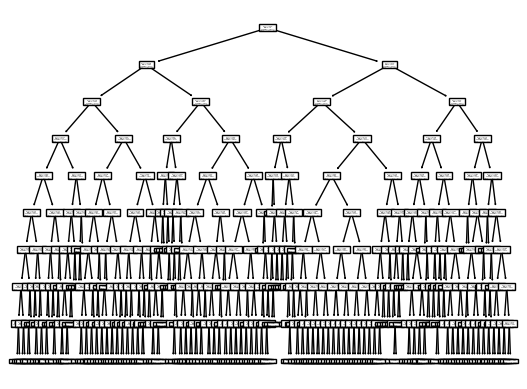

In [34]:
from sklearn import tree
tree.plot_tree(bdt.estimators_[0])

[Text(0.5250868055555555, 0.95, 'X[0] <= 1.006\ngini = 0.5\nsamples = 160000\nvalue = [0.501, 0.499]'),
 Text(0.24322916666666666, 0.85, 'X[2] <= 0.01\ngini = 0.5\nsamples = 153348\nvalue = [0.483, 0.481]'),
 Text(0.14166666666666666, 0.75, 'X[0] <= 0.821\ngini = 0.5\nsamples = 10939\nvalue = [0.022, 0.021]'),
 Text(0.11944444444444445, 0.65, 'X[0] <= 0.787\ngini = 0.5\nsamples = 10244\nvalue = [0.021, 0.02]'),
 Text(0.10833333333333334, 0.55, 'X[3] <= 0.005\ngini = 0.5\nsamples = 10081\nvalue = [0.021, 0.02]'),
 Text(0.09722222222222222, 0.45, 'gini = 0.488\nsamples = 223\nvalue = [0.0, 0.001]'),
 Text(0.11944444444444445, 0.45, 'X[1] <= 10.5\ngini = 0.499\nsamples = 9858\nvalue = [0.02, 0.019]'),
 Text(0.07222222222222222, 0.35, 'X[3] <= 0.075\ngini = 0.493\nsamples = 3328\nvalue = [0.004, 0.004]'),
 Text(0.044444444444444446, 0.25, 'X[3] <= 0.058\ngini = 0.467\nsamples = 1175\nvalue = [0.002, 0.001]'),
 Text(0.022222222222222223, 0.15, 'X[1] <= 7.5\ngini = 0.494\nsamples = 810\nvalu

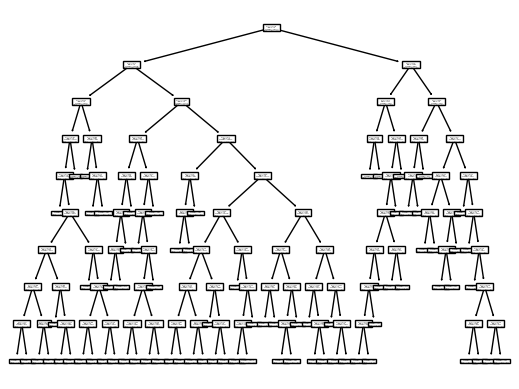

In [35]:
tree.plot_tree(bdt.estimators_[-1])

# Backup